## Training ESRGAN for Super-Resolution

- Scroll to the end to look at beautifully reconstructed images!

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
torch.cuda.empty_cache() 

In [2]:
print(len(os.listdir("dataset/Dataset/HR")))
print(len(os.listdir("dataset/Dataset/LR")))

10000
10000


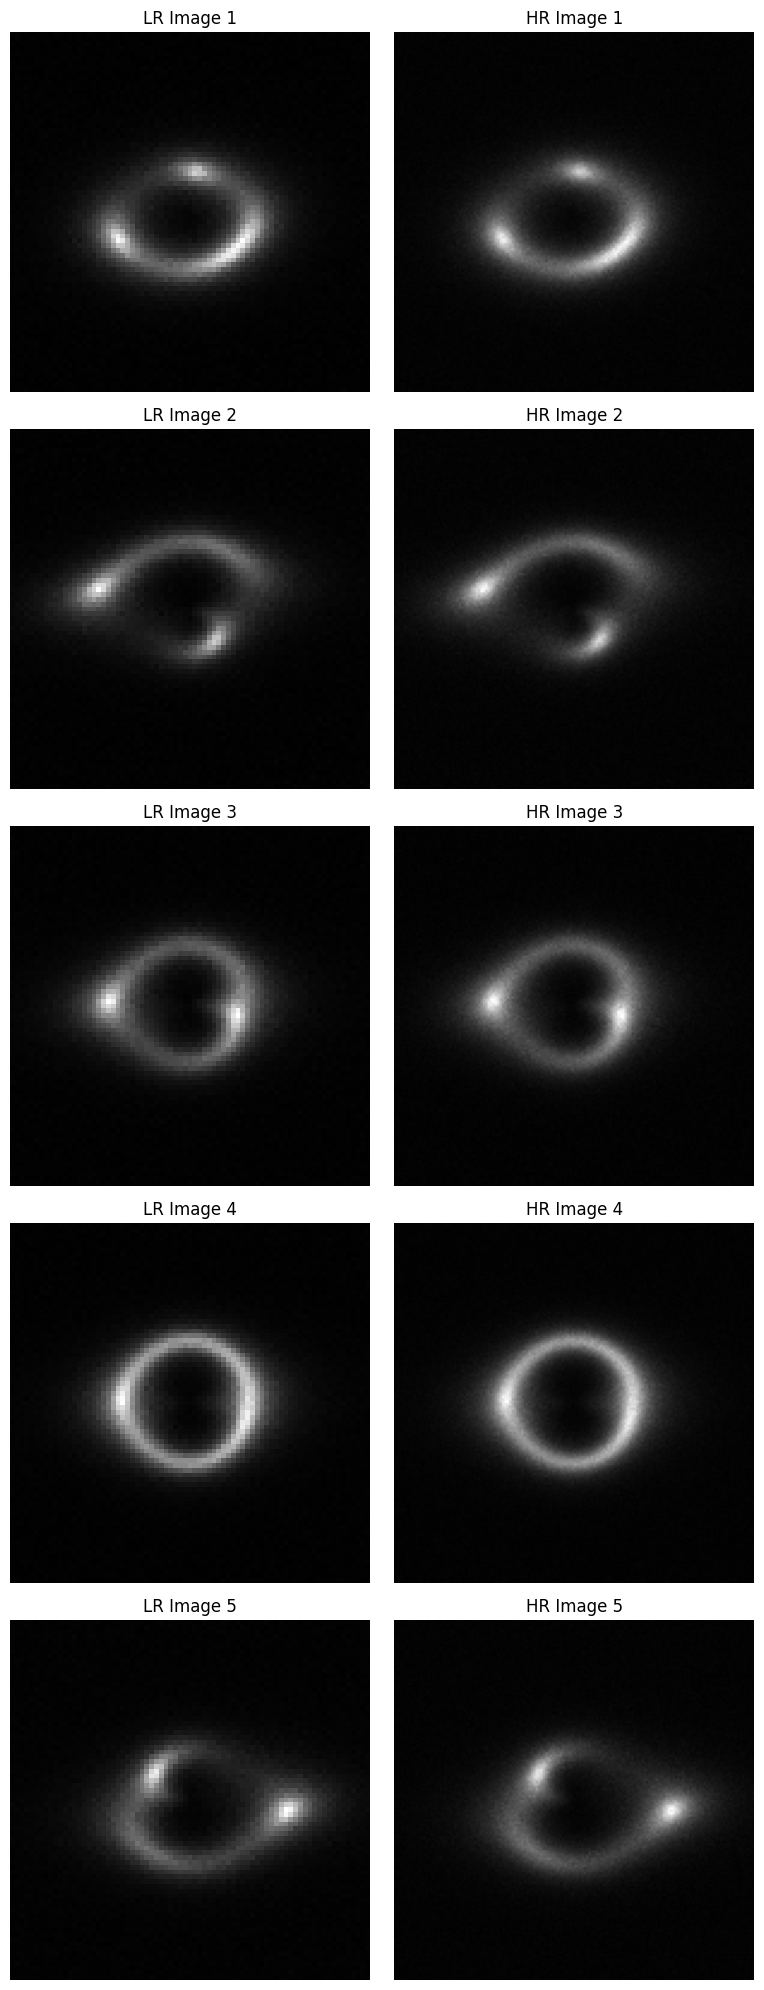

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define dataset paths
dataset_path = "dataset/Dataset"  # Please update the path as per the directory structure you are using! [sorry for having to do this]
hr_path = os.path.join(dataset_path, "HR")
lr_path = os.path.join(dataset_path, "LR")

# Ensure directories exist
if not os.path.exists(hr_path) or not os.path.exists(lr_path):
    raise FileNotFoundError("HR or LR directory not found. Check your dataset path.")

# List .npy files in HR and LR directories
hr_files = sorted([f for f in os.listdir(hr_path) if f.endswith(".npy")])
lr_files = sorted([f for f in os.listdir(lr_path) if f.endswith(".npy")])

# Check if HR and LR datasets are aligned
if len(hr_files) != len(lr_files):
    raise ValueError("Mismatch in number of HR and LR images.")

# Load a few samples for visualization
num_samples = min(5, len(hr_files))  # Adjust number of samples to display

hr_images = [np.load(os.path.join(hr_path, hr_files[i])).squeeze() for i in range(num_samples)]
lr_images = [np.load(os.path.join(lr_path, lr_files[i])).squeeze() for i in range(num_samples)]

# Plot HR and LR images side by side
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

for i in range(num_samples):
    axes[i, 0].imshow(lr_images[i], cmap="gray")
    axes[i, 0].set_title(f"LR Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(hr_images[i], cmap="gray")
    axes[i, 1].set_title(f"HR Image {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:

# Define Masked Autoencoder
class MaskedAutoencoder(nn.Module):
    def __init__(self, img_size=64, hidden_dim=256, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.mask_ratio = mask_ratio
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        mask = (torch.rand_like(x) > self.mask_ratio).float()
        masked_x = x * mask
        encoded = self.encoder(masked_x)
        reconstructed = self.decoder(encoded)
        return reconstructed, mask

In [6]:
# Load the saved MAE model
mae_finetune = MaskedAutoencoder().to(device)
mae_finetune.load_state_dict(torch.load("../Task VI A/mae_pretrained.pth"))

print("Pretrained MAE model loaded successfully!")


Pretrained MAE model loaded successfully!


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


# Train-Validation Split (80% Train, 10% Validation)
train_lr, val_lr, train_hr, val_hr = train_test_split(lr_files, hr_files, test_size=0.1, random_state=42)

class SuperResolutionDataset(Dataset):
    def __init__(self, lr_files, hr_files, lr_dir, hr_dir):
        self.lr_files = [os.path.join(lr_dir, f) for f in lr_files]
        self.hr_files = [os.path.join(hr_dir, f) for f in hr_files]

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        lr_image = np.load(self.lr_files[idx]).squeeze()
        hr_image = np.load(self.hr_files[idx]).squeeze()

        # Convert to PyTorch tensors and normalize
        lr_tensor = torch.tensor(lr_image, dtype=torch.float32).unsqueeze(0)
        hr_tensor = torch.tensor(hr_image, dtype=torch.float32).unsqueeze(0)

        return lr_tensor, hr_tensor

train_dataset = SuperResolutionDataset(train_lr, train_hr, lr_path, hr_path)
val_dataset = SuperResolutionDataset(val_lr, val_hr, lr_path, hr_path)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Training Samples: 9000, Validation Samples: 1000


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """ Residual Block used in the ESRGAN Generator """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))

class ESRGANGenerator(nn.Module):
    """ ESRGAN Generator with MAE Feature Extractor """
    def __init__(self, mae_encoder, upscale_factor=2, num_residual_blocks=16):
        super(ESRGANGenerator, self).__init__()
        self.encoder = mae_encoder  # Pretrained MAE Encoder

        # Upsampling layers
        self.conv1 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Final upsampling layers
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),  # Upscales by 2
            nn.PReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # Final output
        )

    def forward(self, x):
        x = self.encoder(x)  # Extract features using MAE
        x = self.conv1(x)
        x = self.residual_blocks(x)
        x = self.conv2(x)
        x = self.upsample(x)
        return x

# Initialize ESRGAN with MAE
mae_encoder = mae_finetune.encoder  # Use MAE encoder
generator = ESRGANGenerator(mae_encoder).to(device)


In [9]:
class ESRGANDiscriminator(nn.Module):
    """ Discriminator Network for ESRGAN with Adaptive Pooling """
    def __init__(self):
        super(ESRGANDiscriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # Adaptive pooling to ensure the feature map is 9x9
            nn.AdaptiveAvgPool2d((9, 9)),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 9 * 9, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        features = self.features(x)
        out = self.classifier(features)
        return out


# Initialize Discriminator
discriminator = ESRGANDiscriminator().to(device)


In [10]:
from lpips import LPIPS
import torch.optim as optim

# Adversarial Loss
adversarial_loss = nn.BCELoss()

# Pixel Loss (MSE)
pixel_loss = nn.MSELoss()

# Perceptual Loss (LPIPS for feature similarity)
perceptual_loss = LPIPS(net="vgg").to(device) # A 538m vgg model will be downloaded here

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [11]:
num_epochs = 20
best_val_loss = float("inf")

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    total_g_loss = 0.0
    total_d_loss = 0.0

    # ---- Train ESRGAN on Training Data ----
    for lr_imgs, hr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_labels = torch.ones(hr_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_imgs.size(0), 1).to(device)

        real_loss = adversarial_loss(discriminator(hr_imgs), real_labels)
        sr_imgs = generator(lr_imgs)
        fake_loss = adversarial_loss(discriminator(sr_imgs.detach()), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        sr_imgs = generator(lr_imgs)

        # Loss terms
        adv_loss = adversarial_loss(discriminator(sr_imgs), real_labels)
        perc_loss = perceptual_loss(sr_imgs, hr_imgs).mean()
        pix_loss = pixel_loss(sr_imgs, hr_imgs)

        g_loss = pix_loss + 0.01 * adv_loss + 0.1 * perc_loss  # Weighted sum of losses
        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)

    # ---- Validation Phase ----
    generator.eval()
    total_val_loss = 0.0
    total_psnr = 0.0

    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            sr_imgs = generator(lr_imgs)
            val_loss = pixel_loss(sr_imgs, hr_imgs) + 0.1 * perceptual_loss(sr_imgs, hr_imgs).mean()

            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train G Loss: {avg_g_loss:.6f}, Train D Loss: {avg_d_loss:.6f}")
    print(f"  Val Loss: {avg_val_loss:.6f}")

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(generator.state_dict(), "best_esrgan_generator.pth")
        torch.save(discriminator.state_dict(), "best_esrgan_discriminator.pth")
        print("  ** Best Model Saved **")


Epoch [1/20]
  Train G Loss: 0.032003, Train D Loss: 0.658388
  Val Loss: 0.007397
  ** Best Model Saved **
Epoch [2/20]
  Train G Loss: 0.014567, Train D Loss: 0.671973
  Val Loss: 0.005684
  ** Best Model Saved **
Epoch [3/20]
  Train G Loss: 0.012155, Train D Loss: 0.693131
  Val Loss: 0.004609
  ** Best Model Saved **
Epoch [4/20]
  Train G Loss: 0.011603, Train D Loss: 0.689148
  Val Loss: 0.004724
Epoch [5/20]
  Train G Loss: 0.011553, Train D Loss: 0.691121
  Val Loss: 0.003885
  ** Best Model Saved **
Epoch [6/20]
  Train G Loss: 0.011563, Train D Loss: 0.690976
  Val Loss: 0.005793
Epoch [7/20]
  Train G Loss: 0.011391, Train D Loss: 0.691352
  Val Loss: 0.004164
Epoch [8/20]
  Train G Loss: 0.011436, Train D Loss: 0.690696
  Val Loss: 0.004244
Epoch [9/20]
  Train G Loss: 0.011254, Train D Loss: 0.692554
  Val Loss: 0.004002
Epoch [10/20]
  Train G Loss: 0.011275, Train D Loss: 0.693650
  Val Loss: 0.003490
  ** Best Model Saved **
Epoch [11/20]
  Train G Loss: 0.011151, Trai

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Saving the Model after 20 Epochs ---
# (Place this snippet at the end of your training loop, after the 20th epoch)
torch.save(generator.state_dict(), "epoch20_generator.pth")
torch.save(discriminator.state_dict(), "epoch20_discriminator.pth")
print("20th epoch model saved successfully!")

# --- Loading the Saved Generator Model ---
# Recreate the generator instance using the same architecture and MAE encoder
generator = ESRGANGenerator(mae_encoder).to(device)
generator.load_state_dict(torch.load("epoch20_generator.pth"))
generator.eval()  # Set the generator to evaluation mode



20th epoch model saved successfully!


ESRGANGenerator(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(

Average Evaluation Metrics on Validation Set:
MSE: 0.0001
PSNR: 38.4418
SSIM: 0.9525


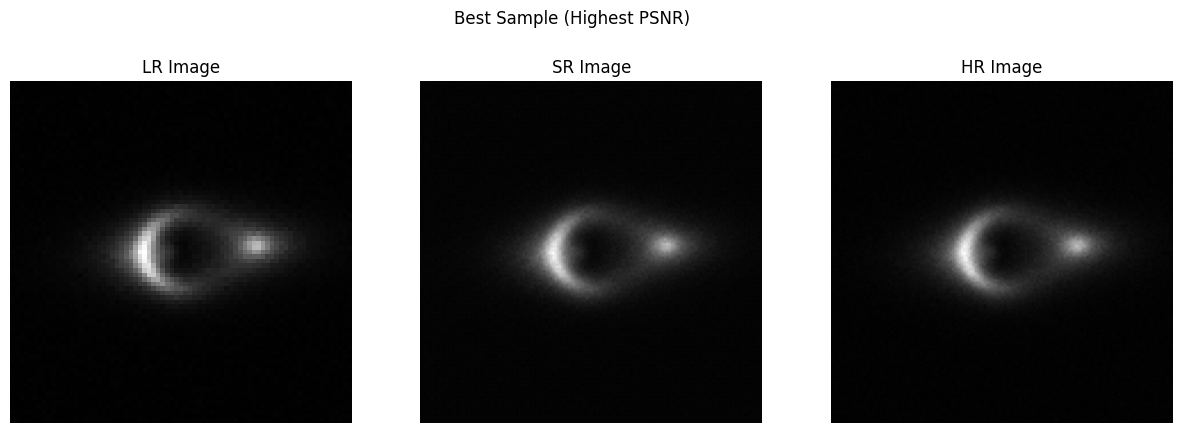

Best Sample Metrics (Index 719): MSE: 0.0001, PSNR: 40.6520, SSIM: 0.9624


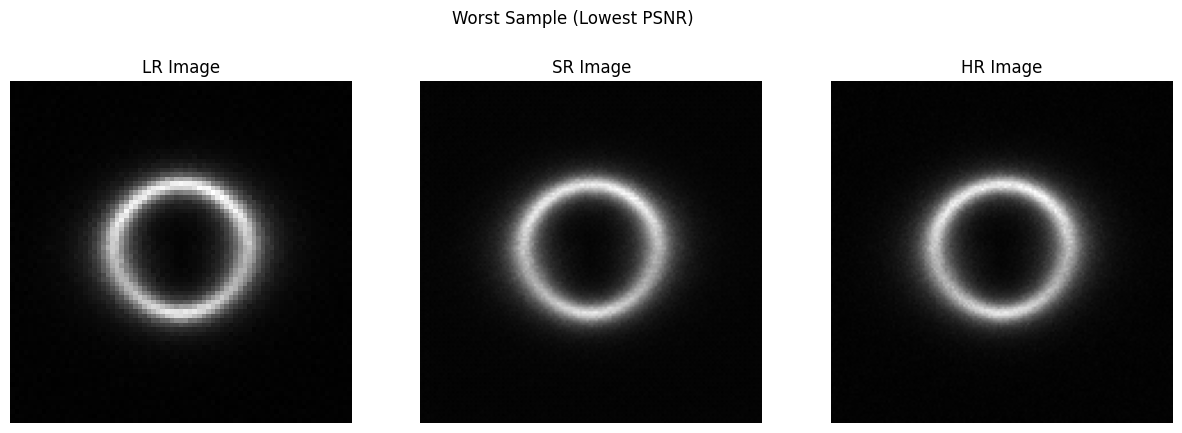

Worst Sample Metrics (Index 646): MSE: 0.0002, PSNR: 36.2981, SSIM: 0.9563


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# Create a DataLoader for the validation set with batch_size=1 for evaluation
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

all_metrics = []

# Loop over each sample in the validation set
for i, (lr_tensor, hr_tensor) in enumerate(val_loader):
    lr_tensor = lr_tensor.to(device)
    hr_tensor = hr_tensor.to(device)
    
    # Generate the super-resolved image (SR)
    with torch.no_grad():
        sr_tensor = generator(lr_tensor)
    
    # Convert tensors to numpy arrays for metric computation and visualization
    lr_image = lr_tensor.squeeze().cpu().numpy()
    hr_image = hr_tensor.squeeze().cpu().numpy()
    sr_image = sr_tensor.squeeze().cpu().numpy()
    
    # Compute Mean Squared Error (MSE)
    mse_value = np.mean((hr_image - sr_image) ** 2)
    # Compute PSNR; using the dynamic range from hr_image
    psnr_value = psnr(hr_image, sr_image, data_range=hr_image.max() - hr_image.min())
    # Compute SSIM; full=True returns a SSIM map as well, we only need the scalar value here
    ssim_value, _ = ssim(hr_image, sr_image, full=True, data_range=hr_image.max() - hr_image.min())
    
    # Store metrics and images for this sample
    all_metrics.append({
        'index': i,
        'mse': mse_value,
        'psnr': psnr_value,
        'ssim': ssim_value,
        'lr_image': lr_image,
        'sr_image': sr_image,
        'hr_image': hr_image
    })

# Compute average metrics across the entire validation set
avg_mse = np.mean([entry['mse'] for entry in all_metrics])
avg_psnr = np.mean([entry['psnr'] for entry in all_metrics])
avg_ssim = np.mean([entry['ssim'] for entry in all_metrics])

print("Average Evaluation Metrics on Validation Set:")
print("MSE: {:.4f}".format(avg_mse))
print("PSNR: {:.4f}".format(avg_psnr))
print("SSIM: {:.4f}".format(avg_ssim))

# Select the best and worst samples based on PSNR (higher PSNR is better)
best_sample = max(all_metrics, key=lambda x: x['psnr'])
worst_sample = min(all_metrics, key=lambda x: x['psnr'])

# --- Display the Best Sample ---
plt.figure(figsize=(15, 5))
plt.suptitle("Best Sample (Highest PSNR)")
plt.subplot(1, 3, 1)
plt.imshow(best_sample['lr_image'], cmap='gray')
plt.title("LR Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(best_sample['sr_image'], cmap='gray')
plt.title("SR Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(best_sample['hr_image'], cmap='gray')
plt.title("HR Image")
plt.axis("off")
plt.show()

print("Best Sample Metrics (Index {}): MSE: {:.4f}, PSNR: {:.4f}, SSIM: {:.4f}".format(
    best_sample['index'], best_sample['mse'], best_sample['psnr'], best_sample['ssim']
))

# --- Display the Worst Sample ---
plt.figure(figsize=(15, 5))
plt.suptitle("Worst Sample (Lowest PSNR)")
plt.subplot(1, 3, 1)
plt.imshow(worst_sample['lr_image'], cmap='gray')
plt.title("LR Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(worst_sample['sr_image'], cmap='gray')
plt.title("SR Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(worst_sample['hr_image'], cmap='gray')
plt.title("HR Image")
plt.axis("off")
plt.show()

print("Worst Sample Metrics (Index {}): MSE: {:.4f}, PSNR: {:.4f}, SSIM: {:.4f}".format(
    worst_sample['index'], worst_sample['mse'], worst_sample['psnr'], worst_sample['ssim']
))
